In [9]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline



### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [10]:
df_train = pd.read_csv('task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('task1_test.csv', delimiter = '\t')


In [11]:
print(len(df_train))
print(len(df_test))

55419
13853


In [12]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13818
1       35
Name: count, dtype: int64


### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [14]:
#first processing

def basic_processing(df):
    #lower case
    df['tweet'] = df['tweet'].apply(str.lower)

    #urls
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'https?://([A-Za-z.0-9/])*', '', text))

    #usernames
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'@(\w)+', '', text))

    #split slash
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'/', ' / ', text))
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'\|', '', text)) #remove pipe
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r"\'", '', text))

    #repeated ponctuation
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'([!?.]){2,}', r'\g<1>', text))

    #split dot
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'(\w)\.(\w)', r'\1. \2', text))

    #split hifen
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'(\w)\-(\w)', r'\1 - \2', text))

    #remove •
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'•', '', text))

    #remove ‘’“”
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'[‘’“”~…¿°⌓¬_]', '', text))

    #remove &amp
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'&amp;', 'and', text))

    #remove &lt
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'&lt;', '<', text))

    #remove &gt
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'&gt;', '>', text))

    #delete hashtags
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r'#(\S+)', '', text))

    #separate dots
    df['tweet'] = df['tweet'].apply(lambda text: re.sub(r"(\.+)(\w)", r"\1 \2", text))


basic_processing(df_train)
basic_processing(df_test)


#### Expansão de contrações

Exemplo: "It's" -> "It is"

In [15]:
#expand contractions

def expand_contractions(text):
    expanded_words = list()

    for word in text.split():
        expanded_words.append(contractions.fix(word))
    expanded_text = ' '.join(expanded_words)

    return expanded_text

df_train['tweet'] = df_train['tweet'].apply(expand_contractions)
df_test['tweet'] = df_test['tweet'].apply(expand_contractions)

#### Remoção de emojis

Expressões regulares + 'emoji' package

In [16]:
#remove emoticons

def remove_emoticons(text):
        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                u"\U000feb13-\U000feb18"
                u"\U000fe040"
                                "]+", flags=re.UNICODE)
        
        return emoji_pattern.sub(r'', text)

df_train['tweet'] = df_train['tweet'].apply(remove_emoticons)
df_train['tweet'] = df_train['tweet'].apply(lambda x: emoji.replace_emoji(x, replace = ''))

df_test['tweet'] = df_test['tweet'].apply(remove_emoticons)
df_test['tweet'] = df_test['tweet'].apply(lambda x: emoji.replace_emoji(x, replace = ''))

#### Palavras alongadas

Exemplo: 'goooood' -> 'good'

In [17]:
#elongated words
def normalize(original_sentence):
    normalized_sentence = list()

    for word in original_sentence.split():
        normalized_word = re.sub(r'(\w)\1{2,}', r'\1', word)
        normalized_sentence.append(normalized_word)

    return ' '.join(normalized_sentence)

# df_train['tweet'] = df_train['tweet'].apply(normalize)
# df_test['tweet'] = df_test['tweet'].apply(normalize)

In [ ]:
normalize('goooood')

'god'

#### Retirar números

In [18]:
def replaceNumbers(text):
    replaced_sentence = []
    for word in text.split(' '):
        if not word.startswith('#'):#we ignore the hashtags, numbers can be important
            word = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*','', word)
            replaced_sentence.append(' ')
            replaced_sentence.append(word)
        else:
            replaced_sentence.append(' ')
            replaced_sentence.append(word)
    return ''.join(replaced_sentence)

df_train['tweet'] = df_train['tweet'].apply(replaceNumbers)
df_test['tweet'] = df_test['tweet'].apply(replaceNumbers)

#### Erros de escrita

In [ ]:
# def correct_spelling(sentence):
#     checker = TextBlob(sentence)
#     correct_sentence = checker.correct()
#     return str(correct_sentence)

# df_train['tweet'] = df_train['tweet'].apply(correct_spelling)
# df_test['tweet'] = df_test['tweet'].apply(correct_spelling)

In [ ]:
# def lemma_tokenizer(text):
#     res = list()

#     #criar tokens
#     tk = TweetTokenizer()
#     tokens = tk.tokenize(text)

#     #lemmatizer
#     lemmatizer = WordNetLemmatizer()
#     for token in tokens:
#         res.append(lemmatizer.lemmatize(token))
#     return res


# df_train['tweet'] = df_train['tweet'].apply(lemma_tokenizer)
# df_test['tweet'] = df_test['tweet'].apply(lemma_tokenizer)

#### Tokenization + lemmatization

In [19]:
def lemma_tokenizer(text):
    res = list()

    #criar tokens
    tokens = word_tokenize(text)

    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        res.append(lemmatizer.lemmatize(token))
    return res


df_train['tweet'] = df_train['tweet'].apply(lemma_tokenizer)
df_test['tweet'] = df_test['tweet'].apply(lemma_tokenizer)

#### Remoçao de stopwords

In [20]:
#remove stopwords
def remove_stopwords(original_sentence):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = list()

    for word in original_sentence:
        if word not in stop_words:
            filtered_sentence.append(word)

    return filtered_sentence
    

df_train['tweet'] = df_train['tweet'].apply(remove_stopwords)
df_test['tweet'] = df_test['tweet'].apply(remove_stopwords)

In [ ]:
#jamspell
#textblob - correct sentence

### TF-IDF

In [21]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [22]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [23]:
y_train.value_counts()

class
0    55273
1      146
Name: count, dtype: int64

In [ ]:
#mindf e maxdf
#tweet tokenizer - nltk
#cross_val_score no sklear.model_selection
#hyperparameters
#gridsearchCV

#rf, nb, logistic regression, multilayer perception

In [24]:
def dummy_tokenizer(text):
    return text

In [ ]:
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)),       # Step 1: Apply TF-IDF vectorization
#     ('select_percentile', SelectPercentile(percentile=50))  # Step 2: Select top 50% features
# ])

In [25]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

In [26]:
tfidf

TfidfVectorizer(lowercase=False, stop_words='english',
                tokenizer=<function dummy_tokenizer at 0x000001FB45C9C9D0>)

#### SMOTE

In [27]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [28]:
for i in tfidf.get_feature_names_out():
    print(i)

!
#
$
%
&
(
)
*
+
+=++=
+a
+hello
+pound
+tax
+week
+win
+yrs
,
-
--
-.-
-\
-almost
-breakfast
-but
-chyna
-current
-darin
-do
-dr.
-especially
-from
-gyptian
-henry
-hope
-j
-jboy
-john
-junior
-katie
-khee
-kurt
-lesson
-matthew
-me
-my
-p
-primo
-remi
-review
-s
-section
-snoop
-something-
-tatiana
-the
-themed
-too
-tweets
-two
-uno
-when
-which
-why
-winnie
.
.-
..
...
/
:
:lisa
:looks
;
<
=
=overstimulated
>
?
@
[
\
]
^
^^
^^^^
^he
a++++
a-bear
a-possible
a-r
a.
aa
aaa
aaaaaaaaand
aaaaaaall
aaaaalllll
aaaaand
aaaabssolutely
aaaah
aaaall
aaaand
aaaay
aaagggeeessssss
aaah
aaand
aaarrrggghhh
aaarrrrggghhhhhh
aab
aahaha
aaliyah
aandd
aande
aandm
aandp
aandw
aaron
aarrrggghhhhhh
aaw
aayyyyeee
ab
abandon
abandoned
abbbbb
abbey
abbi
abbreviates
abbreviating
abbreviation
abby
abc
abcmouse
abdomen
abdominal
abduction
abed
abel
abfab
abh
abigail
abigale
ability
abit
able
abnormal
abolished
abolishes
abort
aborted
abortion
abou
abouts
abram
abrams
abroad
abruptly
absence
absol
absolute
abso

In [7]:
def test (tex):
    import re
    return re.sub(r"(\W)'(\w+)", r"\1\2", tex)

In [8]:
test("and 'abnormal'")

"and abnormal'"

In [53]:
feature_names = tfidf.get_feature_names_out()

import pandas as pd
df = pd.DataFrame(X_train_tfidf.todense(), columns=feature_names)
df = pd.concat([df, df_train['class']], axis = 1)
# df.to_csv('tfidf_train.csv', index=False)


### SVM

In [52]:
clf_svm = LinearSVC(C=0.5,class_weight='balanced')
clf_svm.fit(X_train_tfidf, y_train)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_svm))


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13818
           1       0.69      0.63      0.66        35

    accuracy                           1.00     13853
   macro avg       0.84      0.81      0.83     13853
weighted avg       1.00      1.00      1.00     13853



In [100]:
param_grid = {'C': [1, 10, 100, 1000]
              }

grid_svm = RandomizedSearchCV(LinearSVC(max_iter=10000),param_grid, verbose=3, cv=5)
grid_svm.fit(X_train_resampled, y_train_resampled)
y_pred_grid_svm = grid_svm.predict(X_test_tfidf)
print(grid_svm.best_estimator_)

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............................C=1;, score=1.000 total time=   0.5s
[CV 2/5] END ...............................C=1;, score=1.000 total time=   0.3s
[CV 3/5] END ...............................C=1;, score=1.000 total time=   0.2s
[CV 4/5] END ...............................C=1;, score=1.000 total time=   0.2s
[CV 5/5] END ...............................C=1;, score=1.000 total time=   0.2s
[CV 1/5] END ..............................C=10;, score=1.000 total time=   1.1s
[CV 2/5] END ..............................C=10;, score=1.000 total time=   1.4s
[CV 3/5] END ..............................C=10;, score=1.000 total time=   1.2s
[CV 4/5] END ..............................C=10;, score=1.000 total time=   1.1s
[CV 5/5] END ..............................C=10;, score=1.000 total time=   1.5s
[CV 1/5] END .............................C=100;, score=1.000 total time=   7.4s
[CV 2/5] END .............................C=100;,

c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


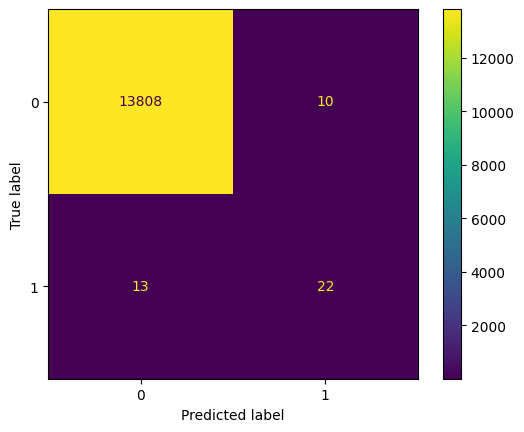

In [27]:
cm = confusion_matrix(y_test, y_pred_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()

### Random forest

In [57]:
clf_rf = RandomForestClassifier(class_weight='balanced')
clf_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = clf_rf.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_rf))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13818
           1       1.00      0.03      0.06        35

    accuracy                           1.00     13853
   macro avg       1.00      0.51      0.53     13853
weighted avg       1.00      1.00      1.00     13853



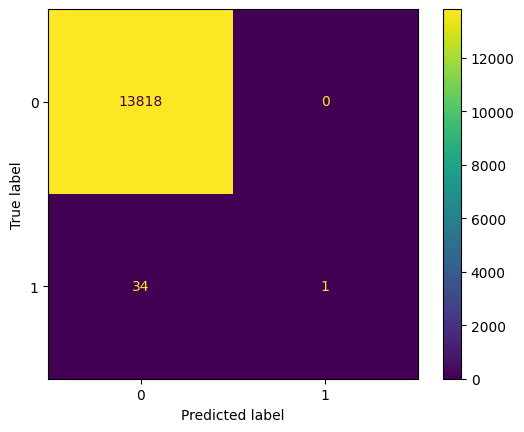

In [58]:
cm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()

### Logistic Regression

In [93]:
clf_lr = LogisticRegression(C= 1000, class_weight='balanced', solver='liblinear', max_iter=10000)
clf_lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = clf_lr.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_lr))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13818
           1       0.85      0.49      0.62        35

    accuracy                           1.00     13853
   macro avg       0.92      0.74      0.81     13853
weighted avg       1.00      1.00      1.00     13853



In [60]:
print("Valores previstos: ", list(y_pred_lr))
print("Valores reais: " , list(y_test))

Valores previstos:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [61]:
param_grid = {'C': [1, 10, 100, 1000],
              'class_weight': ['balanced', None],
              'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}

grid_lr = GridSearchCV(LogisticRegression(max_iter=10000),param_grid, verbose=3, cv=5)
grid_lr.fit(X_train_resampled, y_train_resampled)
y_pred_grid_lr = grid_lr.predict(X_test_tfidf)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.999 total time=   0.9s
[CV 2/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.999 total time=   0.8s
[CV 3/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.999 total time=   0.9s
[CV 4/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.999 total time=   0.8s
[CV 5/5] END C=1, class_weight=balanced, solver=lbfgs;, score=0.999 total time=   0.9s
[CV 1/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.999 total time=   0.2s
[CV 2/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.999 total time=   0.2s
[CV 3/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.999 total time=   0.2s
[CV 4/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.999 total time=   0.2s
[CV 5/5] END C=1, class_weight=balanced, solver=liblinear;, score=0.999 total time=   0.2s
[CV 1/5] END C=1, class_weight=balanced, solver=

In [62]:
print(grid_lr.best_estimator_)

LogisticRegression(C=1000, class_weight='balanced', max_iter=10000,
                   solver='liblinear')


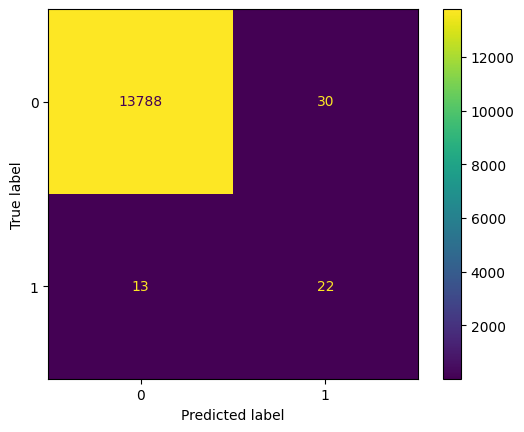

In [63]:
cm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()

### Naive bayes

In [64]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_resampled, y_train_resampled)
y_pred_nb = clf_nb.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_nb))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     13818
           1       0.03      0.60      0.06        35

    accuracy                           0.96     13853
   macro avg       0.52      0.78      0.52     13853
weighted avg       1.00      0.96      0.98     13853



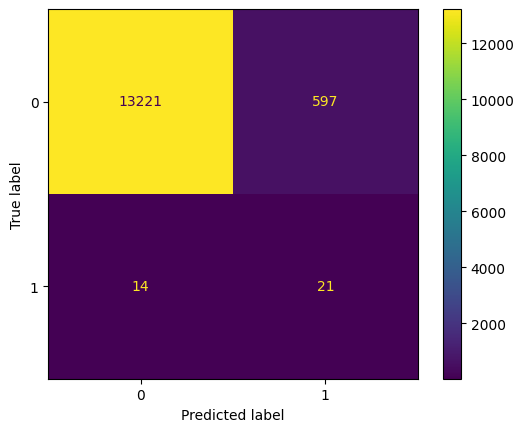

In [65]:
cm = confusion_matrix(y_test, y_pred_nb, labels=clf_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_nb.classes_)
disp.plot()

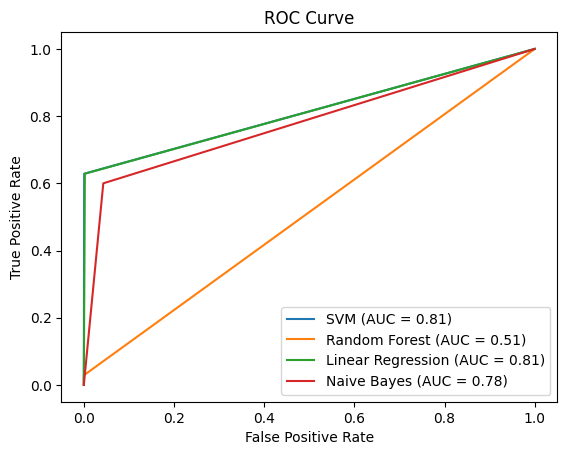

In [66]:
# Compute ROC curve and ROC area for each classifier
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_svm)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_rf)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_lr)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_nb)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

# Plot ROC curves
plt.plot(fpr1, tpr1, label='SVM (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Random Forest (AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Linear Regression (AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='Naive Bayes (AUC = %0.2f)' % roc_auc4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

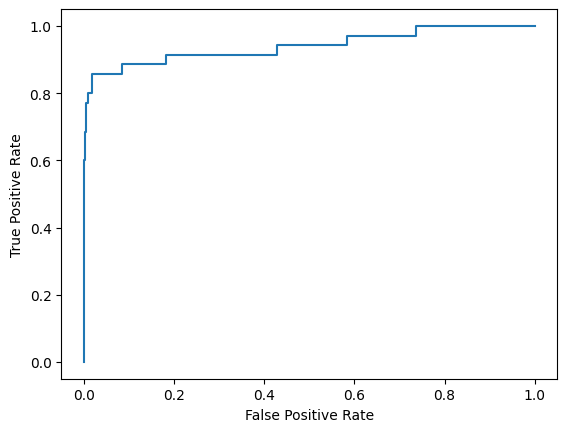

In [67]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = clf_lr.decision_function(X_test_tfidf)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf_nb.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

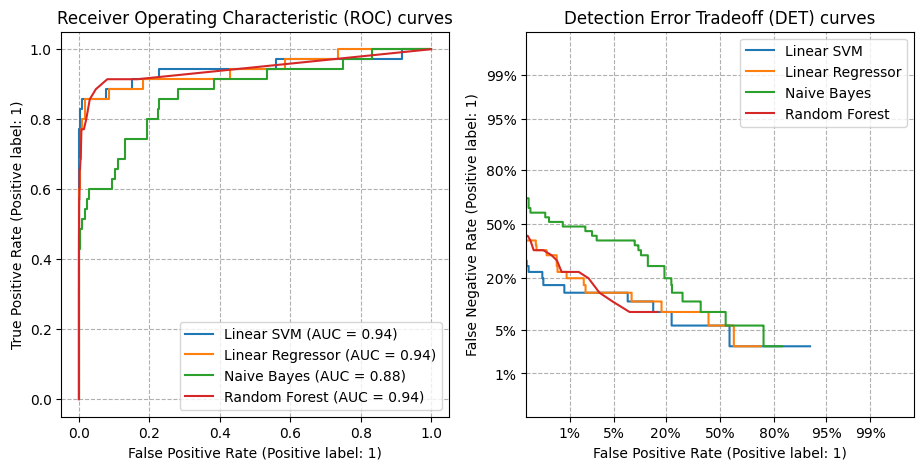

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

classifiers = {
    "Linear SVM": clf_svm,
    "Linear Regressor": clf_lr,
    'Naive Bayes': clf_nb,
    'Random Forest': clf_rf
}

import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)

    RocCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### Ensemble

In [94]:
eclf = VotingClassifier(estimators=[('svm', clf_svm), ('lr', clf_lr), ('nb', clf_nb)],
                        voting='hard', weights=[4,2,1])
eclf.fit(X_train_resampled,y_train_resampled)
y_eclf_pred = eclf.predict(X_test_tfidf)
print(classification_report(y_test, y_eclf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13818
           1       0.79      0.63      0.70        35

    accuracy                           1.00     13853
   macro avg       0.89      0.81      0.85     13853
weighted avg       1.00      1.00      1.00     13853



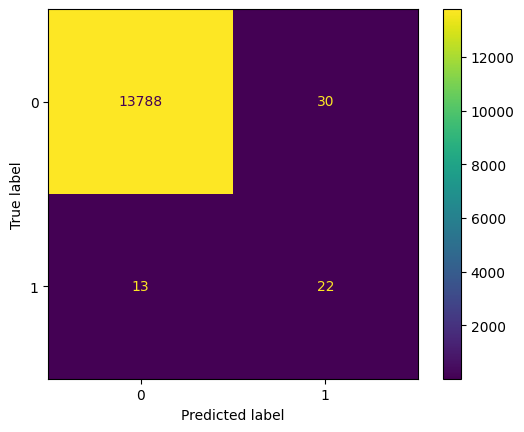

In [70]:
cm = confusion_matrix(y_test, y_eclf_pred, labels=eclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

### MPLClassifier

In [46]:
clf_mpl = MLPClassifier()
clf_mpl.fit(X_train_resampled, y_train_resampled)
y_pred_mlp = clf_mpl.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_mlp))

Classification Report
              precision    recall  f1-score   support

           0       0.70      1.00      0.83     13818
           1       1.00      0.58      0.73     13818

    accuracy                           0.79     27636
   macro avg       0.85      0.79      0.78     27636
weighted avg       0.85      0.79      0.78     27636



c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
